In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore, create_net_capital, strip_strings

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [4]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

age         workclass education_level  education-num         marital-status         occupation   relationship                race     sex  capital-gain  capital-loss  hours-per-week native-country income
0   39   State-gov         Bachelors       13.0           Never-married          Adm-clerical       Not-in-family  White               Male    2174.0        0.0           40.0            United-States  <=50K
1   50   Self-emp-not-inc  Bachelors       13.0           Married-civ-spouse     Exec-managerial    Husband        White               Male    0.0           0.0           13.0            United-States  <=50K
2   38   Private           HS-grad         9.0            Divorced               Handlers-cleaners  Not-in-family  White               Male    0.0           0.0           40.0            United-States  <=50K
3   53   Private           11th            7.0            Married-civ-spouse     Handlers-cleaners  Husband        Black               Male    0.0           0.0           40.0            United-States  <=50K
4   28   Private           Bachelors       13.0           Married-civ-spouse     Prof-specialty     Wife           Black               Female  0.0           0.0           40.0            Cuba           <=50K
5   37   Private           Masters         14.0           Married-civ-spouse     Exec-managerial    Wife           White               Female  0.0           0.0           40.0            United-States  <=50K
6   49   Private           9th             5.0            Married-spouse-absent  Other-service      Not-in-family  Black               Female  0.0           0.0           16.0            Jamaica        <=50K
7   52   Self-emp-not-inc  HS-grad         9.0            Married-civ-spouse     Exec-managerial    Husband        White               Male    0.0           0.0           45.0            United-States  >50K 
8   31   Private           Masters         14.0           Never-married          Prof-specialty     Not-in-family  White               Female  14084.0       0.0           50.0            United-States  >50K 
9   42   Private           Bachelors       13.0           Married-civ-spouse     Exec-managerial    Husband        White               Male    5178.0        0.0           40.0            United-States  >50K 
10  37   Private           Some-college    10.0           Married-civ-spouse     Exec-managerial    Husband        Black               Male    0.0           0.0           80.0            United-States  >50K 
11  30   State-gov         Bachelors       13.0           Married-civ-spouse     Prof-specialty     Husband        Asian-Pac-Islander  Male    0.0           0.0           40.0            India          >50K 
12  23   Private           Bachelors       13.0           Never-married          Adm-clerical       Own-child      White               Female  0.0           0.0           30.0            United-States  <=50K
13  32   Private           Assoc-acdm      12.0           Never-married          Sales              Not-in-family  Black               Male    0.0           0.0           50.0            United-States  <=50K
14  34   Private           7th-8th         4.0            Married-civ-spouse     Transport-moving   Husband        Amer-Indian-Eskimo  Male    0.0           0.0           45.0            Mexico         <=50K
15  25   Self-emp-not-inc  HS-grad         9.0            Never-married          Farming-fishing    Own-child      White               Male    0.0           0.0           35.0            United-States  <=50K
16  32   Private           HS-grad         9.0            Never-married          Machine-op-inspct  Unmarried      White               Male    0.0           0.0           40.0            United-States  <=50K
17  38   Private           11th            7.0            Married-civ-spouse     Sales              Husband        White               Male    0.0           0.0           50.0            United-States  <=50K
18  43   Self-emp-not-inc  Masters         14.0     

In [5]:
n_positive = np.sum(explore.dataset[target_variable] == positive_class)
n_negative = np.sum(explore.dataset.income == negative_class)
scale_pos_weight_calc = n_negative / n_positive
scale_pos_weight_calc

3.034796573875803

In [6]:
global_transformations = [
    # kaggle test file has white space around values
    oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                  custom_function=strip_strings),
    oo.ImputationTransformer(),
    oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                               custom_function=column_log),
    oo.StatelessTransformer(custom_function=create_net_capital),
    oo.CenterScaleTransformer(),
    oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [7]:
model_infos = [oo.ModelInfo(description='Extra-Trees',
                            model=oo.RandomForestClassifier(extra_trees_implementation=True),
                            hyper_params=oo.RandomForestHP(
                                criterion='gini',
                                num_features=None,
                                max_features=1.0,
                                n_estimators=3750,
                                max_depth=14,
                            )),
               oo.ModelInfo(description='RF',
                            model=oo.RandomForestClassifier(),
                            hyper_params=oo.RandomForestHP(
                                criterion='gini',
                                num_features=None,
                                max_features=0.2,
                                n_estimators=1815,
                                max_depth=20,
                                min_samples_split=16,
                                min_samples_leaf=2,
                                min_weight_fraction_leaf=0.0,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0,
                            )),
               oo.ModelInfo(description='AdaBoost',
                            model=oo.AdaBoostClassifier(),
                            hyper_params=oo.AdaBoostClassifierHP(
                                n_estimators=4250,
                                learning_rate=0.45,
                                algorithm='SAMME.R',
                                # Tree-specific hyper-params
                                criterion='gini',
                                splitter='best',
                                max_features=0.3,
                                max_depth=2,
                                min_samples_split=0.7,
                                min_samples_leaf=0.004,
                                min_weight_fraction_leaf=0.,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.,
                                class_weight=None,
                            )),
               oo.ModelInfo(description='Logistic',
                            model=oo.LogisticClassifier(),
                            hyper_params=oo.LogisticClassifierHP(
                                penalty='l2',
                                regularization_inverse=0.245
                            )),
               oo.ModelInfo(description='SVM',
                            model=oo.SvmLinearClassifier(),
                            hyper_params=oo.SvmLinearClassifierHP(
                                penalty='l2',
                                penalty_c=10,
                            )),
               oo.ModelInfo(description='XGBoost',
                            model=oo.XGBoostClassifier(),
                            hyper_params=oo.XGBoostTreeHP(
                                objective=oo.XGBObjective.BINARY_LOGISTIC,
                                learning_rate=0.045,
                                n_estimators=3000,
                                max_depth=3,
                                min_child_weight=5,
                                gamma=0.15,
                                subsample=1,
                                colsample_bytree=0.4,
                                reg_alpha=0,
                                reg_lambda=2,
                                scale_pos_weight=scale_pos_weight_calc,
                         )),
]

In [8]:
score_list = [
    oo.AucRocScore(positive_class=positive_class)
]

# Tune Model Stacker

In [9]:
# stacking_transformations = None
# stacking_model = oo.LogisticClassifier()
# hyper_param_object = oo.LogisticClassifierHP()
# grid = oo.HyperParamsGrid(params_dict=dict(
#     regularization_inverse=[0.001, 0.01, 0.05, 0.1, 1, 5, 8, 10],
# ))

# tuner.results.best_hyper_params
# {'regularization_inverse': 10.0}

# tuner.results.best_model_resampler_object.score_means
# {'AUC_ROC': 0.9289753405569474}

In [10]:
# don't need stacking transformations because by the time it gets to the stacker
stacking_transformations = None
include_original_dataset = False
stacking_model = oo.XGBoostClassifier()
hyper_param_object = oo.XGBoostTreeHP(
    objective=oo.XGBObjective.BINARY_LOGISTIC,
    
)
grid = oo.HyperParamsGrid(params_dict=dict(
    n_estimators=[600, 650, 700],
    learning_rate=[0.0075, 0.01, 0.0125],
    max_depth=[2, 3],
    scale_pos_weight=[scale_pos_weight_calc, 4, 5],
))

# tuner.results.best_hyper_params
# {'regularization_inverse': 10.0}

# tuner.results.best_model_resampler_object.score_means
# {'AUC_ROC': 0.9289753405569474}

In [11]:
grid.params_grid

n_estimators  learning_rate  max_depth  scale_pos_weight
0   600           0.0075         2          3.034797        
1   600           0.0075         2          4.000000        
2   600           0.0075         2          5.000000        
3   600           0.0075         3          3.034797        
4   600           0.0075         3          4.000000        
5   600           0.0075         3          5.000000        
6   600           0.0100         2          3.034797        
7   600           0.0100         2          4.000000        
8   600           0.0100         2          5.000000        
9   600           0.0100         3          3.034797        
10  600           0.0100         3          4.000000        
11  600           0.0100         3          5.000000        
12  600           0.0125         2          3.034797        
13  600           0.0125         2          4.000000        
14  600           0.0125         2          5.000000        
15  600           0.0125         3          3.034797        
16  600           0.0125         3          4.000000        
17  600           0.0125         3          5.000000        
18  650           0.0075         2          3.034797        
19  650           0.0075         2          4.000000        
20  650           0.0075         2          5.000000        
21  650           0.0075         3          3.034797        
22  650           0.0075         3          4.000000        
23  650           0.0075         3          5.000000        
24  650           0.0100         2          3.034797        
25  650           0.0100         2          4.000000        
26  650           0.0100         2          5.000000        
27  650           0.0100         3          3.034797        
28  650           0.0100         3          4.000000        
29  650           0.0100         3          5.000000        
30  650           0.0125         2          3.034797        
31  650           0.0125         2          4.000000        
32  650           0.0125         2          5.000000        
33  650           0.0125         3          3.034797        
34  650           0.0125         3          4.000000        
35  650           0.0125         3          5.000000        
36  700           0.0075         2          3.034797        
37  700           0.0075         2          4.000000        
38  700           0.0075         2          5.000000        
39  700           0.0075         3          3.034797        
40  700           0.0075         3          4.000000        
41  700           0.0075         3          5.000000        
42  700           0.0100         2          3.034797        
43  700           0.0100         2          4.000000        
44  700           0.0100         2          5.000000        
45  700           0.0100         3          3.034797        
46  700           0.0100         3          4.000000        
47  700           0.0100         3          5.000000        
48  700           0.0125         2          3.034797        
49  700           0.0125         2          4.000000        
50  700           0.0125         2          5.000000        
51  700           0.0125         3          3.034797        
52  700           0.0125         3          4.000000        
53  700           0.0125         3          5.000000

In [12]:
model_stacker = oo.ModelStacker(
    base_models=model_infos,
    scores=score_list,
    stacking_model=stacking_model,
    include_original_dataset=include_original_dataset,
    stacking_transformations=stacking_transformations,
    converter=oo.ExtractPredictionsColumnConverter(column=positive_class),
)
cache_directory = 'stacker_tune_exclude_dataset'
resampler = oo.RepeatedCrossValidationResampler(
    model=model_stacker,
    transformations=global_transformations,
    scores=score_list,
    folds=5,
    repeats=3,
)
tuner = oo.ModelTuner(
    resampler=resampler,
    hyper_param_object=hyper_param_object,
    parallelization_cores=-1,
    model_persistence_manager=oo.LocalCacheManager(cache_directory=cache_directory),
)
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

In [13]:
tuner.results.best_hyper_params

{'n_estimators': 650,
 'learning_rate': 0.01,
 'max_depth': 2,
 'scale_pos_weight': 4.0}

In [14]:
tuner.results.best_model_resampler_object.score_means

{'AUC_ROC': 0.9301384318323013}

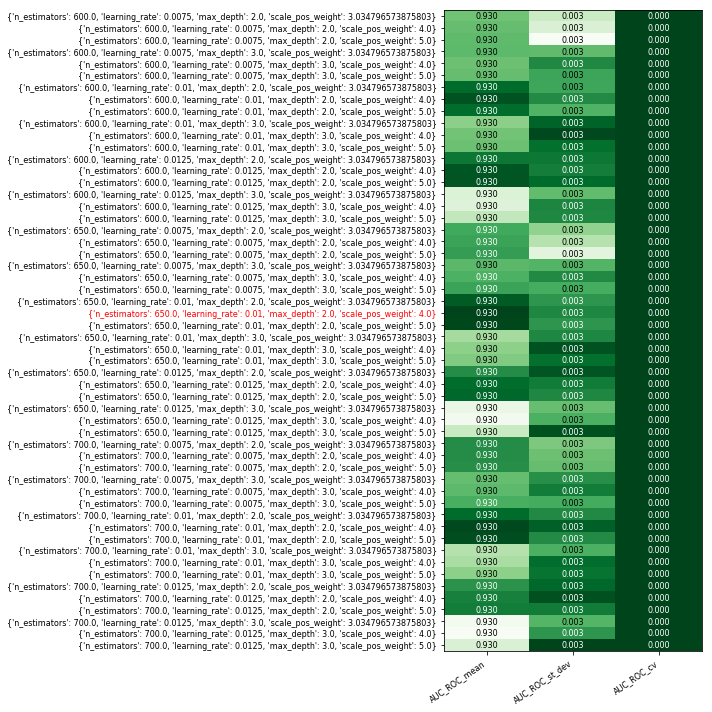

In [15]:
tuner.results.plot_resampled_stats()

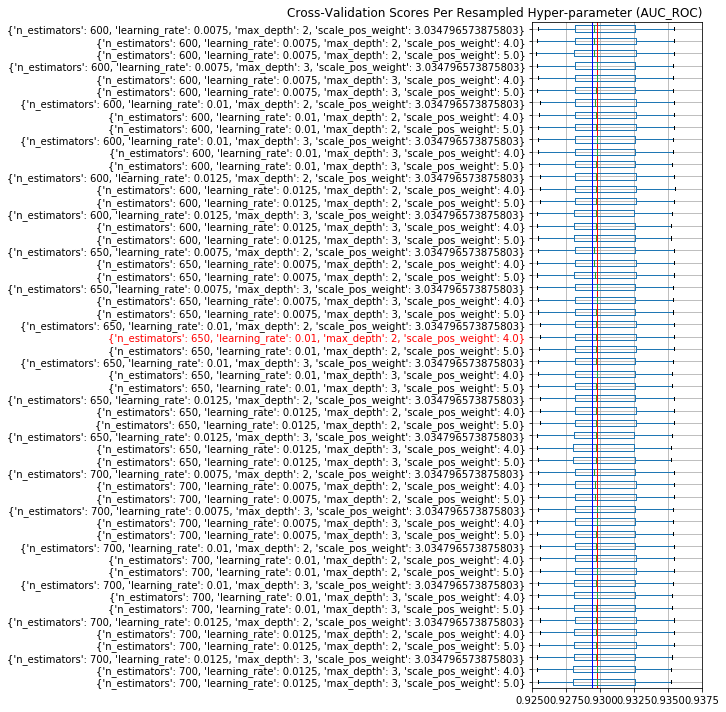

In [24]:
tuner.results.plot_resampled_scores(
    metric=oo.Metric.AUC_ROC,
    x_axis_limits=(0.925, 0.9375),
    show_one_ste_rule=True
)

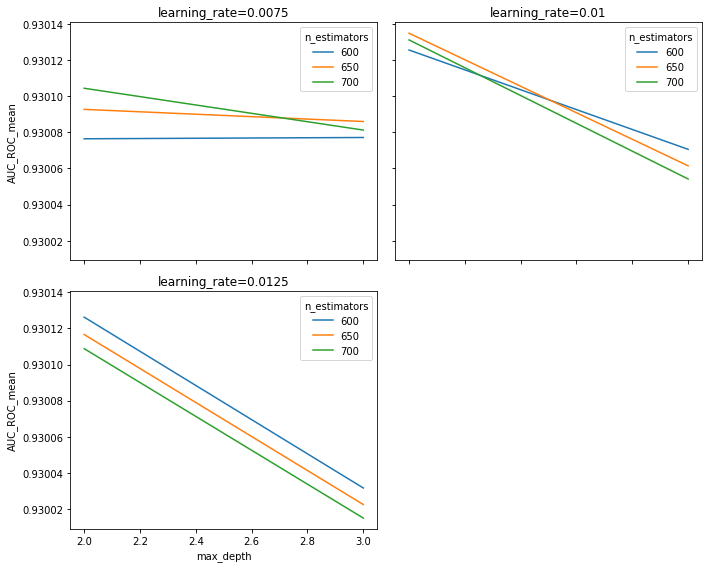

In [17]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='max_depth',
                                        line='n_estimators',
                                        grid='learning_rate'
                                       )

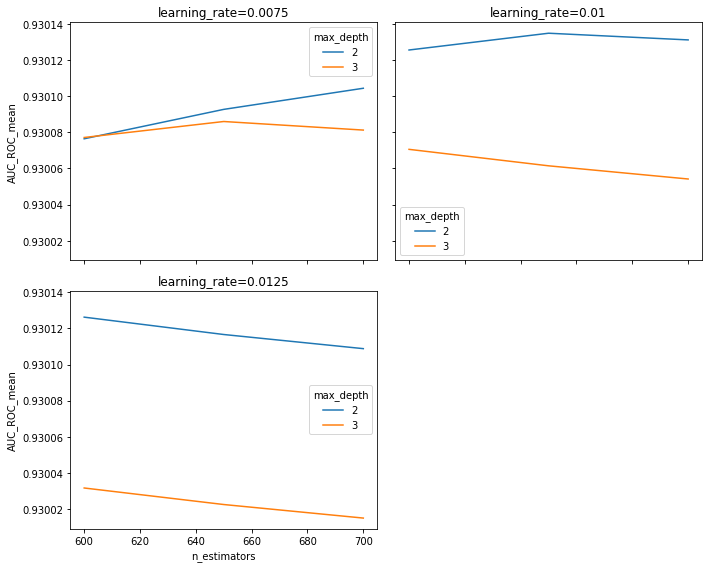

In [18]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='n_estimators',
                                        line='max_depth',
                                        grid='learning_rate'
                                       )

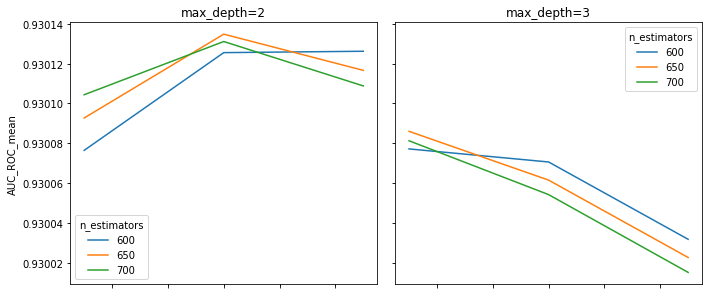

In [19]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='learning_rate',
                                        line='n_estimators',
                                        grid='max_depth'
                                       )

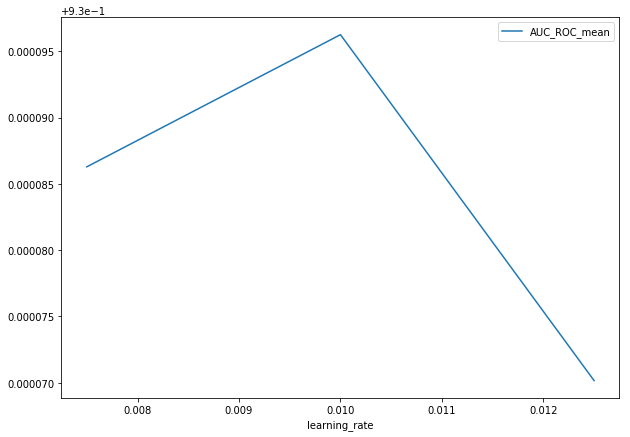

In [20]:
tuner.results.plot_hyper_params_profile(
                                        metric=oo.Metric.AUC_ROC,
                                        x_axis='learning_rate',
#                                         line='n_estimators',
#                                         grid='max_depth'
                                       )

In [21]:
tuner.results

In [22]:
assert False

AssertionError: 

# Train Final Model (All Data)

In [27]:
fitter = oo.ModelTrainer(
    model=model_stacker,
    # transformations for all models, not just stackers
    model_transformations=global_transformations,
    splitter=None,
    scores=[oo.AucRocScore(positive_class=positive_class)],
)
hyper_params = oo.XGBoostTreeHP(
    objective=oo.XGBObjective.BINARY_LOGISTIC,
    
)
hyper_params.params_dict

{'max_depth': 3,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'silent': True,
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'n_jobs': 1,
 'nthread': None,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'missing': None}

In [28]:
tuner.results.best_hyper_params

{'n_estimators': 650,
 'learning_rate': 0.01,
 'max_depth': 2,
 'scale_pos_weight': 4.0}

In [29]:
hyper_params.update_dict(tuner.results.best_hyper_params)
hyper_params.params_dict

{'max_depth': 2,
 'learning_rate': 0.01,
 'n_estimators': 650,
 'silent': True,
 'objective': 'binary:logistic',
 'booster': 'gbtree',
 'n_jobs': 1,
 'nthread': None,
 'gamma': 0,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 4.0,
 'base_score': 0.5,
 'missing': None}

In [30]:
fitter.train_predict_eval(data=explore.dataset,
                          target_variable=target_variable,
                          hyper_params=hyper_params)

<=50K      >50K
0      0.993961  0.006039
1      0.347011  0.652989
2      0.902315  0.097685
3      0.725102  0.274898
4      0.198828  0.801172
5      0.044653  0.955347
6      0.993619  0.006381
7      0.249184  0.750816
8      0.001757  0.998243
9      0.001757  0.998243
10     0.118499  0.881501
11     0.215373  0.784627
12     0.994280  0.005720
13     0.757485  0.242515
14     0.831963  0.168037
15     0.989451  0.010549
16     0.974723  0.025277
17     0.457416  0.542584
18     0.466019  0.533981
19     0.060018  0.939982
20     0.989451  0.010549
21     0.811383  0.188617
22     0.986322  0.013678
23     0.872052  0.127948
24     0.111721  0.888279
25     0.994886  0.005114
26     0.372628  0.627372
27     0.321690  0.678310
28     0.841918  0.158082
29     0.994886  0.005114
30     0.903608  0.096392
31     0.337528  0.662472
32     0.966137  0.033863
33     0.970269  0.029731
34     0.994747  0.005253
35     0.968564  0.031436
36     0.195906  0.804094
37     0.756936  0.243064
38     0.123323  0.876677
39     0.336770  0.663230
40     0.935678  0.064322
41     0.987205  0.012795
42     0.077996  0.922004
43     0.347003  0.652997
44     0.426300  0.573700
45     0.322878  0.677122
46     0.753640  0.246360
47     0.388181  0.611819
48     0.001757  0.998243
49     0.134029  0.865971
50     0.377495  0.622505
51     0.169515  0.830485
52     0.868672  0.131328
53     0.672634  0.327366
54     0.306548  0.693452
55     0.985166  0.014834
56     0.966835  0.033165
57     0.306548  0.693452
58     0.053046  0.946954
59     0.720012  0.279988
60     0.418378  0.581622
61     0.977789  0.022211
62     0.252651  0.747349
63     0.105877  0.894123
64     0.994886  0.005114
65     0.917290  0.082710
66     0.169515  0.830485
67     0.987205  0.012795
68     0.558075  0.441925
69     0.989451  0.010549
70     0.293200  0.706800
71     0.995752  0.004248
72     0.822503  0.177497
73     0.994886  0.005114
74     0.326640  0.673360
75     0.418378  0.581622
76     0.195906  0.804094
77     0.001757  0.998243
78     0.914789  0.085211
79     0.195906  0.804094
80     0.123323  0.876677
81     0.929109  0.070891
82     0.105411  0.894589
83     0.148308  0.851692
84     0.914959  0.085041
85     0.993588  0.006412
86     0.118499  0.881501
87     0.867601  0.132399
88     0.005343  0.994657
89     0.189116  0.810884
90     0.717994  0.282006
91     0.987205  0.012795
92     0.180862  0.819138
93     0.001757  0.998243
94     0.366758  0.633242
95     0.994886  0.005114
96     0.914492  0.085508
97     0.001757  0.998243
98     0.989451  0.010549
99     0.970396  0.029604
100    0.420364  0.579636
101    0.962765  0.037235
102    0.053679  0.946321
103    0.001772  0.998228
104    0.985166  0.014834
105    0.989451  0.010549
106    0.618660  0.381340
107    0.148762  0.851238
108    0.285445  0.714555
109    0.175348  0.824652
110    0.978469  0.021531
111    0.995636  0.004364
112    0.071807  0.928193
113    0.906946  0.093054
114    0.169515  0.830485
115    0.995752  0.004248
116    0.044653  0.955347
117    0.994886  0.005114
118    0.357322  0.642678
119    0.764262  0.235738
120    0.818185  0.181815
121    0.984273  0.015727
122    0.141245  0.858755
123    0.087656  0.912344
124    0.886190  0.113810
125    0.072395  0.927605
126    0.388181  0.611819
127    0.418378  0.581622
128    0.994886  0.005114
129    0.175348  0.824652
130    0.322878  0.677122
131    0.982398  0.017602
132    0.995752  0.004248
133    0.011077  0.988923
134    0.859050  0.140950
135    0.989451  0.010549
136    0.916183  0.083817
137    0.982554  0.017446
138    0.850760  0.149240
139    0.947415  0.052585
140    0.916886  0.083114
141    0.890274  0.109726
142    0.994747  0.005253
143    0.246080  0.753920
144    0.983207  0.016793
145    0.929572  0.070428
146    0.819372  0.180628
147    0.796240  0.203760
148    0.989451  0.010549
149    0.407414  0.592586
150    0.936088  0.063912
151    0.169515  0.830485
152    0.985476  0.014524
153   

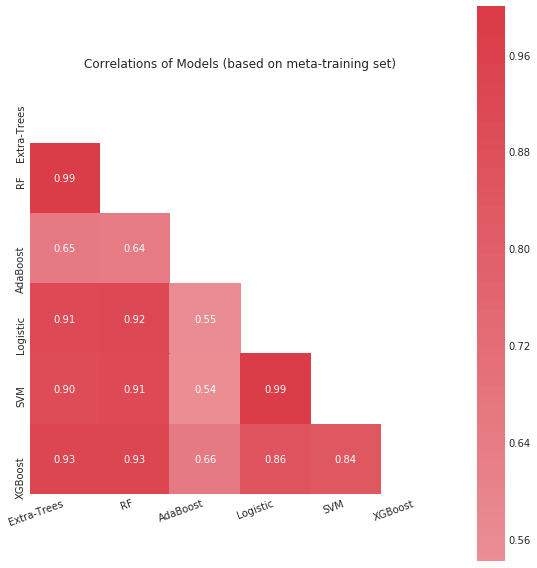

In [31]:
fitter.model.plot_correlation_heatmap()

In [32]:
fitter.training_scores[0].value

0.941313561758401

# Predict on Kaggle Test Set

In [33]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

(45222, 14)

In [34]:
test_dataset.head(100)

Unnamed: 0   age          workclass education_level  education-num          marital-status          occupation     relationship                 race      sex  capital-gain  capital-loss  hours-per-week  native-country
0   0           21.0   Private            10th           6.0             Married-civ-spouse      Craft-repair        Husband          White                Male    0.0           0.0           40.0             United-States
1   1           49.0   Private            Bachelors      13.0            Married-civ-spouse      Adm-clerical        Wife             White                Female  0.0           0.0           40.0             United-States
2   2           44.0   Self-emp-not-inc   Assoc-acdm     12.0            Married-civ-spouse      Other-service       Wife             White                Female  0.0           0.0           99.0             United-States
3   3           34.0   Private            Bachelors      13.0            Married-civ-spouse      Sales               Husband          White                Male    7298.0        0.0           46.0             United-States
4   4           24.0   Private            HS-grad        9.0             Married-civ-spouse      Machine-op-inspct   Husband          White                Male    0.0           0.0           40.0             United-States
5   5           52.0   Private            7th-8th        4.0             Divorced                Priv-house-serv     Own-child        Black                Female  0.0           0.0           16.0             United-States
6   6           61.0   Private            7th-8th        4.0             Married-civ-spouse      Transport-moving    Husband          White                Male    0.0           0.0           50.0             United-States
7   7           24.0   Private            HS-grad        9.0             Married-civ-spouse      Craft-repair        Husband          White                Male    0.0           0.0           40.0             United-States
8   8           30.0   Private            HS-grad        9.0             Never-married           Handlers-cleaners   Not-in-family    White                Male    0.0           0.0           22.0             United-States
9   9           42.0   Local-gov          HS-grad        9.0             Married-civ-spouse      Exec-managerial     Husband          White                Male    0.0           0.0           60.0             United-States
10  10          47.0   Local-gov          Prof-school    15.0            Married-civ-spouse      Prof-specialty      Husband          White                Male    0.0           0.0           35.0             United-States
11  11          42.0   Self-emp-not-inc   Bachelors      13.0            Married-civ-spouse      Craft-repair        Husband          White                Male    15024.0       0.0           60.0             United-States
12  12          58.0   Self-emp-inc       HS-grad        9.0             Married-civ-spouse      Exec-managerial     Husband          White                Male    0.0           0.0           40.0             United-States
13  13          28.0   Self-emp-not-inc   Some-college   10.0            Never-married           Prof-specialty      Own-child        White                Male    0.0           0.0           30.0             United-States
14  14          30.0   Self-emp-inc       Bachelors      13.0            Married-civ-spouse      Sales               Husband          White                Male    0.0           0.0           52.0             United-States
15  15          48.0   Local-gov          Masters        14.0            Married-civ-spouse      Prof-specialty      Husband          White                Male    0.0           0.0           40.0             United-States
16  16          55.0   Private            HS-grad        9.0             Married-civ-spouse      Craft-repair        Husband          White                Male    0.0           0.0           40.0             United-States
17  17  

In [35]:
indexes = test_dataset['Unnamed: 0']

predictions = fitter.predict(test_dataset.drop(columns='Unnamed: 0'))
predictions.head(10)

<=50K      >50K
0  0.944646  0.055354
1  0.105877  0.894123
2  0.466900  0.533100
3  0.001757  0.998243
4  0.819530  0.180470
5  0.995752  0.004248
6  0.473275  0.526725
7  0.731968  0.268032
8  0.984273  0.015727
9  0.194070  0.805930

In [36]:
income_value = predictions['>50K']
new_predictions = pd.DataFrame({'id': indexes, 'income': income_value})
new_predictions.to_csv('submission_ModelStacker_without_dataset.csv', index=False)

# Results

## 1)

Kaggle Public: ``

File: `submission_ModelStacker_x.csv`

Parameters: 

```

```